<a href="https://colab.research.google.com/github/khanyousefzai/IEEE_Kaggle_Chalenge/blob/master/IEEE_Kaggle_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
IEEE KAGGLE COMPETITION
IEEE Fraud Detection 2019
Prize: 20,000 Dollars
Date:09/05/2019
Author: 
Saad
"""

'\nIEEE KAGGLE COMPETITION\nIEEE Fraud Detection 2019\nPrize: 20,000 Dollars\nDate:09/05/2019\nAuthor: \nSaad\n'

In [2]:
#library imports
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
#import descartes
from keras.models import Sequential
from scipy.stats import chisquare, chi2_contingency, chi2
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import io
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from keras import regularizers
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler
import time
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [0]:
#Reading Data using pandas
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
sample_submision = pd.read_csv('sample_submission.csv')

In [17]:
%%time
#finding the dataset dimensions
print(train_transaction.shape, train_identity.shape)
print(test_transaction.shape, test_identity.shape)
#Merging the data set with transactions and identity in train and test.
#checking the time
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

(590540, 394) (144233, 41)
(506691, 393) (141907, 41)
CPU times: user 10.3 s, sys: 3.59 s, total: 13.9 s
Wall time: 13.9 s


In [18]:
%%time
#remove the extra data frame to save some memory
del train_transaction
del train_identity
del test_identity
del test_transaction

CPU times: user 40.1 ms, sys: 13 ms, total: 53.1 ms
Wall time: 53.5 ms


In [20]:
%%time
#Writing function to reduce memory
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)                            
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.34 µs


In [21]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of properties dataframe is : 1959.8762512207031  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  isFraud
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  TransactionDT
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  float64
d

In [30]:
#Checking Missing and Categorical Varaibles
#Checking categorical varaiables
cat_cols = list(train.select_dtypes(include=['object']).columns)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,99,150,discover,142,credit,315,87,19,65535,NaN,NaN,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14,65535,13,-123,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404,150,mastercard,102,credit,325,87,65535,65535,gmail.com,NaN,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490,150,visa,166,debit,330,87,287,65535,outlook.com,NaN,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567,150,mastercard,117,debit,476,87,65535,65535,yahoo.com,NaN,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112,112,0,94,0,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514,150,mastercard,102,credit,420,87,65535,65535,gmail.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0,65535,65535,-123,65535,-84,65535,-1.0,-1.0,...,0,70787,-14,-29,-73,-101,-47,-101,-37,-101,100.0,NotFound,9,-480,New,NotFound,166,9,542,144,99,9,NaN,10,99,99,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [48]:
train.head(100)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,99,150,discover,142,credit,315,87,19,65535,NaN,NaN,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14,65535,13,-123,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.00,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404,150,mastercard,102,credit,325,87,65535,65535,gmail.com,NaN,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.00,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490,150,visa,166,debit,330,87,287,65535,outlook.com,NaN,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.00,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567,150,mastercard,117,debit,476,87,65535,65535,yahoo.com,NaN,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112,112,0,94,0,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.00,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514,150,mastercard,102,credit,420,87,65535,65535,gmail.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0,65535,65535,-123,65535,-84,65535,-1.0,-1.0,...,0,70787,-14,-29,-73,-101,-47,-101,-37,-101,100.00,NotFound,9,-480,New,NotFound,166,9,542,144,99,9,NaN,10,99,99,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.000000,W,5937,555,150,visa,226,debit,272,87,36,65535,gmail.com,NaN,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.00,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.000000,W,12308,360,150,visa,166,debit,126,87,0,65535,yahoo.com,NaN,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.00,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.500000,W,12695,490,150,visa,226,debit,325,87,65535,65535,mail.com,NaN,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.00,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.000000,H,2803,100,150,visa,226,debit,337,87,65535,65535,anonymous.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0,65535,65535,-123,65535,-84,65535,-1.0,-1.0,...,-5,98945,-14,-29,0,-5,-47,-101,-37,-101,100.00,NotFound,49,-300,New,NotFound,166,9,621,500,99,9,NaN,10,99,99,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.000000,W,17399,111,150,mastercard,224,debit,204,87,19,65535,yahoo.com,NaN,2,2,0,0,0,3,0,0,3,0,1,0,12,2,61,61,30,318,30,-84,65535,-1.0,-1.0,...,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.00,NaN,9,-661,NaN,NaN,99,9,99,99,99,9,NaN,10,99,99,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
test.shape[1]

433

In [47]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.7]
    return many_null_cols
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(dropna=False, normalize=True).values[0] > 0.7]
    return big_top_value_cols
def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 70% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 70% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove('isFraud')
    return cols_to_drop
cols_to_drop = get_useless_columns(train)

More than 70% null: 18
More than 70% repeated value: 344


In [66]:
train.columns = train.columns.astype(str)
print(cols_to_drop)

['id_37', 'V304', 'V223', 'id_04', 'D12', 'V122', 'V254', 'V273', 'V77', 'V117', 'V157', 'V164', 'V172', 'V293', 'V155', 'C4', 'V237', 'V56', 'V276', 'V257', 'V275', 'V125', 'V14', 'V101', 'id_09', 'V34', 'V205', 'V230', 'id_19', 'V144', 'V163', 'id_21', 'V244', 'V93', 'V71', 'V116', 'V280', 'V126', 'V158', 'id_28', 'id_23', 'V233', 'V339', 'V25', 'V227', 'V266', 'V55', 'V174', 'V138', 'V106', 'V110', 'V297', 'V263', 'id_33', 'V261', 'C12', 'V57', 'V212', 'V330', 'V105', 'V23', 'V256', 'id_22', 'V200', 'V107', 'V95', 'V85', 'V97', 'V239', 'V63', 'V131', 'V225', 'V213', 'V203', 'V289', 'card6', 'D7', 'V303', 'V64', 'V154', 'V217', 'V120', 'V267', 'V287', 'id_15', 'V21', 'V156', 'V199', 'V269', 'V194', 'V148', 'V216', 'V184', 'V248', 'V18', 'V229', 'V313', 'V311', 'V182', 'id_25', 'V316', 'addr2', 'V135', 'ProductCD', 'id_13', 'V66', 'V15', 'V262', 'V322', 'V115', 'V306', 'V176', 'V299', 'V103', 'id_31', 'V124', 'V137', 'card3', 'V326', 'V214', 'id_34', 'C10', 'id_35', 'V314', 'V234', 'V

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167

In [76]:
train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
card1                  0
card2                  0
card4               1577
card5                  0
addr1                  0
dist1                  0
P_emaildomain      94456
C1                     0
C2                     0
C5                     0
C6                     0
C9                     0
C11                    0
C13                    0
C14                    0
D1                     0
D2                     0
D3                     0
D4                     0
D5                     0
D10                    0
D11                    0
D15                    0
M1                271100
M2                271100
M3                271100
                   ...  
V44                    0
V45                    0
V46                    0
V47                    0
V48                    0
V49                    0
V50                    0
V51                    0
V52                    0


Text(0, 0.5, 'Missing rate')

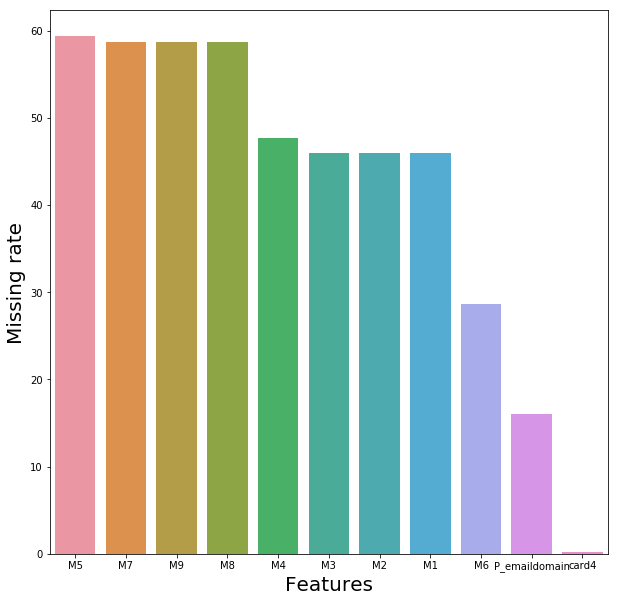

In [75]:
data_null = train.isnull().sum()/len(train) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data.head()
plt.subplots(figsize=(10,10))
#plt.xticks(rotation='0')
sns.barplot(data_null.index, data_null)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Missing rate', fontsize=20)

In [85]:
train['M3'].describe()

count     319440
unique         2
top            T
freq      251731
Name: M3, dtype: object

In [68]:
for i in train.columns:
    for j in cols_to_drop:        
        if(i == j):
            del train[i]
train.shape

(590540, 91)

In [0]:
# Now we need to check the attribute the missing
# First calculate the columns which constitude missing ratio
# Then delete the columns which has more than 80 percent of the rows are empty
data_null = train.isnull().sum()/len(train) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data.head(433)
#Defining function to delete which has more than 85 percent null values

,Missing Ratio
id_23,98.889993
id_27,98.889993
id_33,82.183404
id_30,80.818456
id_34,80.798647
M7,77.427910
M8,77.427910
M9,77.427910
DeviceInfo,73.916313
id_16,72.075962


In [0]:
categorical_features = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain',
    'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

continuous_features = list(filter(lambda x: x not in categorical_features, train))

In [0]:
x = pd.DataFrame(continuous_features)
x.head()

NameError: ignored